# Анализ проходимости курса Stepik "Введение в анализ данных на R" 

**Проблема:**  
Мало людей, которые начали курс, доходят до конца (success rate 5-10%). Необходимо понять, почему пользователи бросают курс и предсказать, перестанет ли пользователь учиться на курсе.
  
Как добиться повышения success rate без значительного изменения курса?  
Что делать, чтобы пользователь, который собирается покинуть курс, не ушел?

**Анализ проблемы:**   
Как часто студенты проходят курс?  
На каких заданиях возникли трудности?  
Стали ли эти трудности причиной потерей заинтересованности в курсе и дальнейшего ухода?  
Какие действия приводят к тому, что пользователь не доходит до конца?  
Какие действия свидетельствуют об успешном прохождении курса?  

**Решение:**  
Задача классификации, 2 класса студентов: "закончил курс", "бросил курс".  
Создание модели, которая будет предсказывать на основе активности ученика в течение первых дней, закончит ли он курс.  
Нахождение мест в курсе, которые вызывают у учеников трудности и демотивируют продолжать прохождение курса.

Описание данных:  
**events_train.csv - данные о действиях, которые совершают студенты со стэпами**  
1. step_id - id стэпа 
2. user_id - анонимизированный id юзера  
3. timestamp - время наступления события в формате unix date
4. action - событие, возможные значения: 
* discovered - пользователь перешел на стэп  
* viewed - просмотр шага
* started_attempt - начало попытки решить шаг, ранее нужно было явно нажать на кнопку - начать решение, перед тем как приступить к решению практического шага
* passed - удачное решение практического шага  

**submissions_train.csv - данные о времени и статусах сабмитов к практическим заданиям**
1. step_id - id стэпа
2. timestamp - время отправки решения в формате unix date
3. submission_status - статус решения
4. user_id - анонимизированный id юзера

In [852]:
# импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [853]:
# чтение данных
events = pd.read_csv('https://stepik.org/media/attachments/course/4852/event_data_train.zip', compression ='zip')
events.head()

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632


In [854]:
# просмотр возможных событий
events.action.unique()

array(['viewed', 'passed', 'discovered', 'started_attempt'], dtype=object)

### Перевод времени timestamp в другой формат
Документация: https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html

In [855]:
events['date'] = pd.to_datetime(events['timestamp'], unit='s')
events.head()

,step_id,timestamp,action,user_id,date
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48
1,32815,1434340848,passed,17632,2015-06-15 04:00:48
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35


In [856]:
events.dtypes

step_id               int64
timestamp             int64
action               object
user_id               int64
date         datetime64[ns]
dtype: object

In [857]:
# первое действие на курсе и последняя запись
print(events.date.min())
print(events.date.max())

2015-06-15 04:00:48
2018-05-19 23:33:31


In [858]:
events['day'] = events.date.dt.date
events.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


### График активности студентов за все время
По количеству **уникальных** пользователей за день

In [859]:
sns.set(rc={'figure.figsize': (9, 6)}) # чтобы даты не накладывались друг на друга

<AxesSubplot:xlabel='day'>

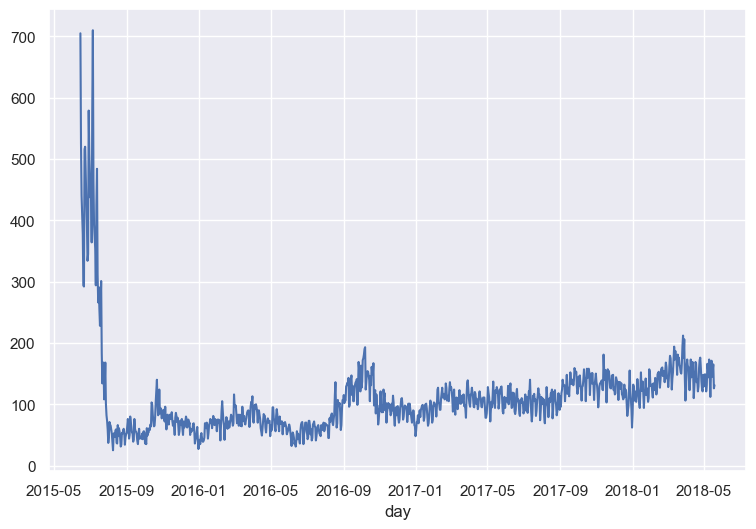

In [860]:
events.groupby('day').user_id.nunique().plot()

С начала запуска на курс многие записались, тем более, если его активно рекламировали, а затем волна прошла и все стабилизировалось.

### Распределение пользователей по количеству набранных за курс баллов

<AxesSubplot:>

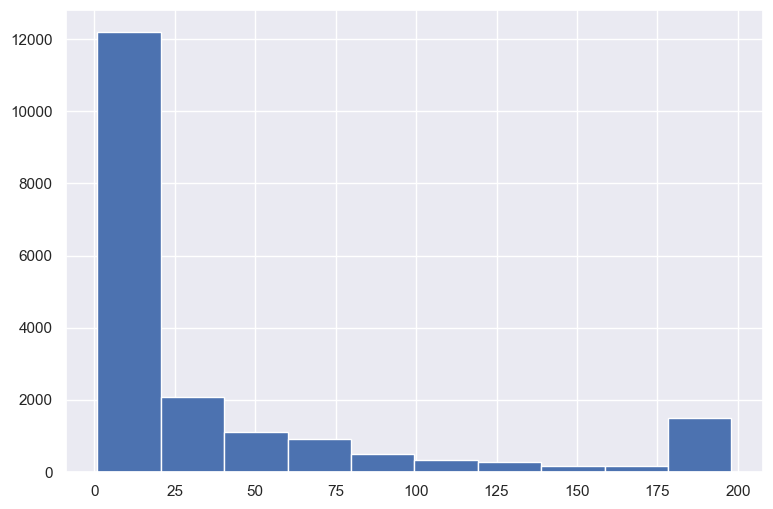

In [956]:
events.groupby("user_id").step_id.nunique().hist()

Некоторые люди решили не проходить курс до конца, некоторые постепенно проходят.

In [957]:
events.pivot_table(index='user_id', # каждая строчка будет информацией о каждом уникальном index
               columns='action', # столбцы будут отвечать за уникальные значения columns 
               values='step_id', # в ячейках будет находиться информация по values
               aggfunc='count', # сгруппированная по aggfunc
               fill_value=0).reset_index()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1
...,...,...,...,...,...
19229,26790,8,8,1,9
19230,26793,1,0,1,1
19231,26794,69,69,34,180
19232,26797,10,10,2,13


In [863]:
# чтение данных
submissions = pd.read_csv('https://stepik.org/media/attachments/course/4852/submissions_data_train.zip', compression ='zip')
submissions.head()

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853


In [864]:
submissions_data = pd.read_csv('https://stepik.org/media/attachments/course/4852/submissions_data_train.zip',compression ='zip')

In [865]:
# предобработка
submissions['date'] = pd.to_datetime(submissions.timestamp, unit='s')
submissions['day'] = submissions.date.dt.date
submissions.head()

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15


### Считаем количество правильных и неправильных ответов учеников за всё время

In [866]:
users_scores = submissions.pivot_table(index='user_id',
               columns='submission_status',
               values='step_id',
               aggfunc='count',
               fill_value=0).reset_index()

users_scores.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


### Расчет перерывов в решении курса
Какой промежуток в днях — порог для бросания курсов?

In [867]:
# список уникальных дней на курсе
gap_data = events[['user_id', 'day', 'timestamp']].drop_duplicates(subset = ['user_id', 'day']) \
    .groupby('user_id')['timestamp'].apply(list) \
    .apply(np.diff).values # разность между ближайшими уникальными днями на курсе
    # values дает массив массивов

In [868]:
gap_data = pd.Series(np.concatenate(gap_data, axis=0))
# разница перерыва в днях
gap_data = gap_data / (24 * 60 * 60)
gap_data

0         56.060208
1         79.852419
2          2.112083
3          1.084606
4         32.047106
            ...    
97867    166.056586
97868      5.845613
97869      1.137176
97870      0.659942
97871     18.148032
Length: 97872, dtype: float64

In [869]:
# разница перерыва в днях
gap_data / (24 * 60 * 60)

0        0.000649
1        0.000924
2        0.000024
3        0.000013
4        0.000371
           ...   
97867    0.001922
97868    0.000068
97869    0.000013
97870    0.000008
97871    0.000210
Length: 97872, dtype: float64

<AxesSubplot:>

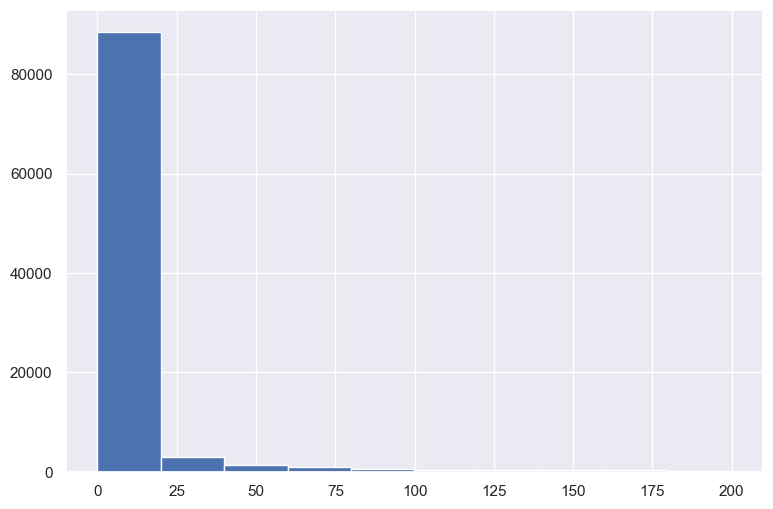

In [870]:
gap_data[gap_data < 200].hist()

In [871]:
gap_data.quantile(0.95)

59.760440972222156

## Только ~ 5% пользователей возвращаются на курс после перерыва в 2 месяца.

Гипотеза: у автора курса много правильных ответов => он будет в начале списка id

In [872]:
users_scores.sort_values(by='correct', ascending=False)

submission_status,user_id,correct,wrong
439,1046,421,513
2099,5552,186,93
6415,17135,168,177
2344,6183,142,65
3208,8461,135,42
...,...,...,...
551,1321,0,2
9778,26349,0,1
3559,9422,0,1
5014,13408,0,2


### Если человек не получил сертификат и отсутствует более 30 дней, то считаем, что к курсу он не вернется

In [873]:
# финальный день
now = events.timestamp.max()
# пороговое значение
drop_out = 30 * 24 * 60 * 60 # 30 дней

In [874]:
# рассчитываем максимальное время появление на курсе у каждого пользователя
users_data = events.groupby('user_id', as_index=False) \
    .agg({'timestamp':'max'}).rename(columns={'timestamp':'last_timestamp'})

users_data.head()

,user_id,last_timestamp
0,1,1472827464
1,2,1519226966
2,3,1444581588
3,5,1499859939
4,7,1521634660


In [875]:
users_data['is_gone_user'] = (now - users_data.last_timestamp) > drop_out
users_data.head()

,user_id,last_timestamp,is_gone_user
0,1,1472827464,True
1,2,1519226966,True
2,3,1444581588,True
3,5,1499859939,True
4,7,1521634660,True


In [876]:
users_data = users_data.merge(users_scores, on='user_id', how='outer') # outer чтобы не потерять пользователей, 
                                                                 # у которых значения попыток 0
users_data = users_data.fillna(0)

In [877]:
users_events_data = events.pivot_table(index='user_id',
               columns='action',
               values='step_id',
               aggfunc='count',
               fill_value=0).reset_index()

users_data = users_data.merge(users_events_data, how='outer')

In [878]:
# уникальные дни на Stepik для каждого пользователя
users_days = events.groupby('user_id').day.nunique().to_frame().reset_index()
users_days.head()

,user_id,day
0,1,1
1,2,2
2,3,7
3,5,2
4,7,1


In [879]:
users_data = users_data.merge(users_days, how='outer')

In [880]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day
0,1,1472827464,True,0.0,0.0,1,0,0,1,1
1,2,1519226966,True,2.0,0.0,9,9,2,10,2
2,3,1444581588,True,29.0,23.0,91,87,30,192,7
3,5,1499859939,True,2.0,2.0,11,11,4,12,2
4,7,1521634660,True,0.0,0.0,1,1,0,1,1


In [881]:
# проверяем, что не потеряли пользователей
print(users_days.user_id.nunique()) # после обработки
print(events.user_id.nunique()) # в исходных данных

19234
19234


In [882]:
# проверка на то, что человек успешно прошёл курс = набрал более 170 баллов
users_data['passed_course'] = users_data.passed > 170
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False


In [883]:
users_data.groupby('passed_course').count()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day
passed_course,,,,,,,,,,
False,17809,17809,17809,17809,17809,17809,17809,17809,17809,17809
True,1425,1425,1425,1425,1425,1425,1425,1425,1425,1425


In [884]:
1425 / (17809 + 1425) * 100 # доля прошедших курс

7.408755329104711

## Всего ~ 7% людей прошли курс

In [885]:
users_data['passed_course'].value_counts(normalize=True)

False    0.925912
True     0.074088
Name: passed_course, dtype: float64

## Прогнозирование оттока пользователей с курса

Цель — как можно раньше предсказать, что пользователь покинет курс на Stepik

Можно ли, анализируя поведение пользователей за первые n дней, предсказать, что пользователь пройдет / не пройдет курс до конца?

<AxesSubplot:>

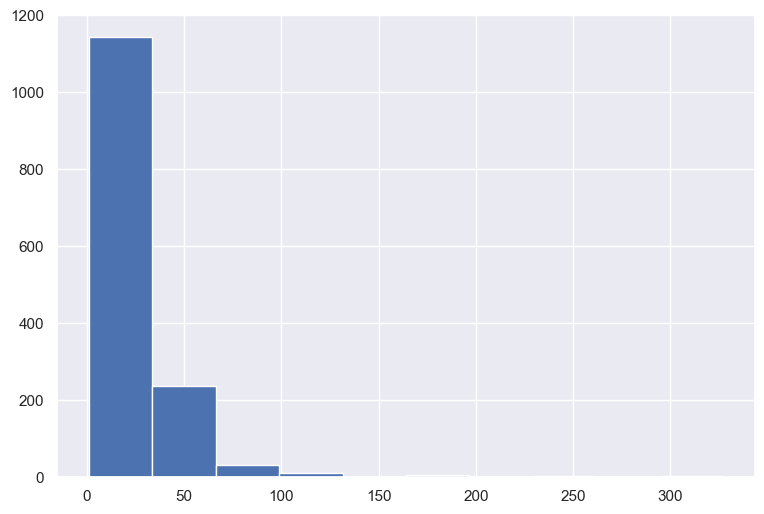

In [886]:
users_data[users_data.passed_course].day.hist()

### Отобрать наблюдения для обучения
Рассматриваем события в течение 14 дней

In [887]:
user_min_time = events.groupby('user_id') \
    .agg({'timestamp':'min'}) \
    .rename({'timestamp':'min_timestamp'}, axis=1)

In [888]:
user_min_time.head()

,min_timestamp
user_id,
1,1472827464
2,1514383364
3,1434358476
5,1466156809
7,1521634660


In [889]:
users_data = users_data.merge(user_min_time, how='outer', on='user_id')
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course,min_timestamp
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False,1472827464
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False,1514383364
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False,1434358476
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False,1466156809
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False,1521634660


In [890]:
events

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15
...,...,...,...,...,...,...
3480698,33375,1526772685,viewed,11677,2018-05-19 23:31:25,2018-05-19
3480699,32815,1526772750,viewed,5198,2018-05-19 23:32:30,2018-05-19
3480700,32815,1526772750,discovered,5198,2018-05-19 23:32:30,2018-05-19
3480701,32815,1526772750,passed,5198,2018-05-19 23:32:30,2018-05-19


In [891]:
events_data_train = events.merge(users_data[['user_id', 'min_timestamp']], on='user_id', how='left') \
    .query("(timestamp - min_timestamp) < (14 * 24 * 60 * 60)")

In [892]:
events_data_train.groupby('user_id').day.nunique().max()

15

In [893]:
submissions_data_train = submissions.merge(user_min_time[['min_timestamp']], on='user_id', how='left') \
    .query("(timestamp - min_timestamp) < (14 * 24 * 60 * 60)")

In [894]:
submissions_data_train.groupby('user_id').day.nunique().max()

15

In [895]:
# датафрейм для хранения информации о пользователях за их первые 3 дня курса
X = submissions_data_train.groupby('user_id').day.nunique().to_frame().reset_index() \
                                    .rename(columns={'day':'days'})
print(X.shape)
X.head()

(9336, 2)


,user_id,days
0,2,1
1,3,1
2,8,1
3,14,1
4,16,10


Решение заданий пользователем: сколько он решил правильно и неправильно?

In [896]:
# сколько уникальных заданий пользователь пытался решить
steps_tried = submissions_data_train.groupby('user_id').step_id.nunique().to_frame().reset_index() \
                                    .rename(columns={'step_id':'steps_tried'})

steps_tried.head()

,user_id,steps_tried
0,2,2
1,3,4
2,8,11
3,14,1
4,16,53


In [897]:
X = X.merge(steps_tried, on='user_id', how='outer')
X.shape

(9336, 3)

In [898]:
X = X.merge(submissions_data_train.pivot_table(index='user_id',
                        columns='submission_status',
                        values='step_id',
                        aggfunc='count',
                        fill_value=0).reset_index())
X.head()

,user_id,days,steps_tried,correct,wrong
0,2,1,2,2,0
1,3,1,4,4,4
2,8,1,11,9,21
3,14,1,1,0,1
4,16,10,53,52,69


In [899]:
# количество правильных ответов относительно всех
X['correct_ratio'] = X['correct'] / (X['correct'] + X['wrong'])
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio
0,2,1,2,2,0,1.000000
1,3,1,4,4,4,0.500000
2,8,1,11,9,21,0.300000
3,14,1,1,0,1,0.000000
4,16,10,53,52,69,0.429752


Просмотр заданий пользователем: сколько шагов курса он посмотрел? Пользователь мог посмотреть задания, но не пытаться их решить. 

In [900]:
X.shape

(9336, 6)

In [901]:
X = X.merge(events_data_train.pivot_table(index='user_id',
                                         columns ='action',
                                         values='step_id',
                                         aggfunc='count',
                                         fill_value=0).reset_index()[['user_id','viewed']], how='outer')
print(X.shape)
X.head()

(19234, 7)


,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed
0,2,1.0,2.0,2.0,0.0,1.000000,9
1,3,1.0,4.0,4.0,4.0,0.500000,20
2,8,1.0,11.0,9.0,21.0,0.300000,156
3,14,1.0,1.0,0.0,1.0,0.000000,9
4,16,10.0,53.0,52.0,69.0,0.429752,288


In [902]:
# пропуски данных заполняем 0
X = X.fillna(0)

In [903]:
# человек закончил курс успешно и больше не делает попыток
X = X.merge(users_data[['user_id', 'passed_course', 'is_gone_user']], how='outer')
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed,passed_course,is_gone_user
0,2,1.0,2.0,2.0,0.0,1.000000,9,False,True
1,3,1.0,4.0,4.0,4.0,0.500000,20,False,True
2,8,1.0,11.0,9.0,21.0,0.300000,156,False,True
3,14,1.0,1.0,0.0,1.0,0.000000,9,False,True
4,16,10.0,53.0,52.0,69.0,0.429752,288,True,True


In [904]:
# не нужно рассматривать пользователей, про статус которых мы не знаем - они пока не закончили курс, но не бросили его
X = X[~((X.is_gone_user == False) & (X.passed_course == False))]
# эквивалентно X.is_gone_user | X.passed_course
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed,passed_course,is_gone_user
0,2,1.0,2.0,2.0,0.0,1.000000,9,False,True
1,3,1.0,4.0,4.0,4.0,0.500000,20,False,True
2,8,1.0,11.0,9.0,21.0,0.300000,156,False,True
3,14,1.0,1.0,0.0,1.0,0.000000,9,False,True
4,16,10.0,53.0,52.0,69.0,0.429752,288,True,True


В датафрейме X теперь храняется наблюдения, где человек прошел курс либо не прошел курс и бросил его.

In [905]:
X.groupby(['passed_course', 'is_gone_user']).user_id.count()

passed_course  is_gone_user
False          True            16560
True           False             141
               True             1284
Name: user_id, dtype: int64

passed_course = False и is_gone_user = True значит что пользователь не прошел курс и ГАРАНТИРОВАННО бросил его  
Пользователь завершил курс:  
passed_course = True и is_gone_user = False прошел курс совсем недавно

In [906]:
X = X.set_index(X.user_id)
X = X.drop(['user_id'], axis=1)
X.head()

,days,steps_tried,correct,wrong,correct_ratio,viewed,passed_course,is_gone_user
user_id,,,,,,,,
2,1.0,2.0,2.0,0.0,1.000000,9,False,True
3,1.0,4.0,4.0,4.0,0.500000,20,False,True
8,1.0,11.0,9.0,21.0,0.300000,156,False,True
14,1.0,1.0,0.0,1.0,0.000000,9,False,True
16,10.0,53.0,52.0,69.0,0.429752,288,True,True


# Машинное обучение

## Логистическая регрессия

In [907]:
from sklearn.model_selection import train_test_split

In [908]:
# разделим данные на тренировочные и тестовые
X_train, X_test = train_test_split(X, test_size=0.2, random_state=1, stratify=X['passed_course'])

In [909]:
y_train = X_train['passed_course'].copy()
X_train = X_train.drop('passed_course', axis=1)

y_test = X_test['passed_course'].copy()
X_test = X_test.drop('passed_course', axis=1)

In [910]:
print(f'X_train: {X_train.shape}')
print(f'X_test: {X_test.shape}')

X_train: (14388, 7)
X_test: (3597, 7)


In [911]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

In [912]:
# обучение модели
clf = LogisticRegression(random_state=1, max_iter=1000).fit(X_train, y_train)

In [913]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score


print(f'Accuracy  (общая точность) модели равна {round(accuracy_score(y_test, clf.predict(X_test)), 3)}')
print(f'Precision (точность с учетом ложных срабатываний) модели равна {round(precision_score(y_test, clf.predict(X_test)), 3)}')
print(f'Recall    (полнота верных срабатываний) модели равна {round(recall_score(y_test, clf.predict(X_test)), 3)}')
print(f'f1_score  (соотношение точности и полноты) модели равна {round(f1_score(y_test, clf.predict(X_test)), 3)}')

Accuracy  (общая точность) модели равна 0.952
Precision (точность с учетом ложных срабатываний) модели равна 0.834
Recall    (полнота верных срабатываний) модели равна 0.495
f1_score  (соотношение точности и полноты) модели равна 0.621


Accuracy означает, что модель правильно классифицировала 95.2% из всех данных  
Precision указывает на то, что из всех предсказаний моделью как положительные, 83.4% действительно являются положительными    
Recall показывает, что модель смогла обнаружить 49.5% всех истинно положительных примеров  
F1 Score отражает баланс между этими точностью и полнотой. F1-оценка становится высокой <=> и точность, и полнота высоки

## Логистическая регрессия с кросс-валидацией

In [914]:
from sklearn.linear_model import LogisticRegressionCV

In [924]:
clf_cv = LogisticRegressionCV(random_state=2, max_iter=1000).fit(X_train, y_train)

In [925]:
print(f'Accuracy  (общая точность) модели равна {round(accuracy_score(y_test, clf_cv.predict(X_test)), 3)}')
print(f'Precision (точность с учетом ложных срабатываний) модели равна {round(precision_score(y_test, clf_cv.predict(X_test)), 3)}')
print(f'Recall    (полнота верных срабатываний) модели равна {round(recall_score(y_test, clf_cv.predict(X_test)), 3)}')
print(f'f1_score  (соотношение точности и полноты) модели равна {round(f1_score(y_test, clf_cv.predict(X_test)), 3)}')

Accuracy  (общая точность) модели равна 0.952
Precision (точность с учетом ложных срабатываний) модели равна 0.834
Recall    (полнота верных срабатываний) модели равна 0.495
f1_score  (соотношение точности и полноты) модели равна 0.621


## Дерево решений

In [926]:
from sklearn import tree

In [928]:
clf_tree = tree.DecisionTreeClassifier(random_state=3).fit(X_train, y_train)

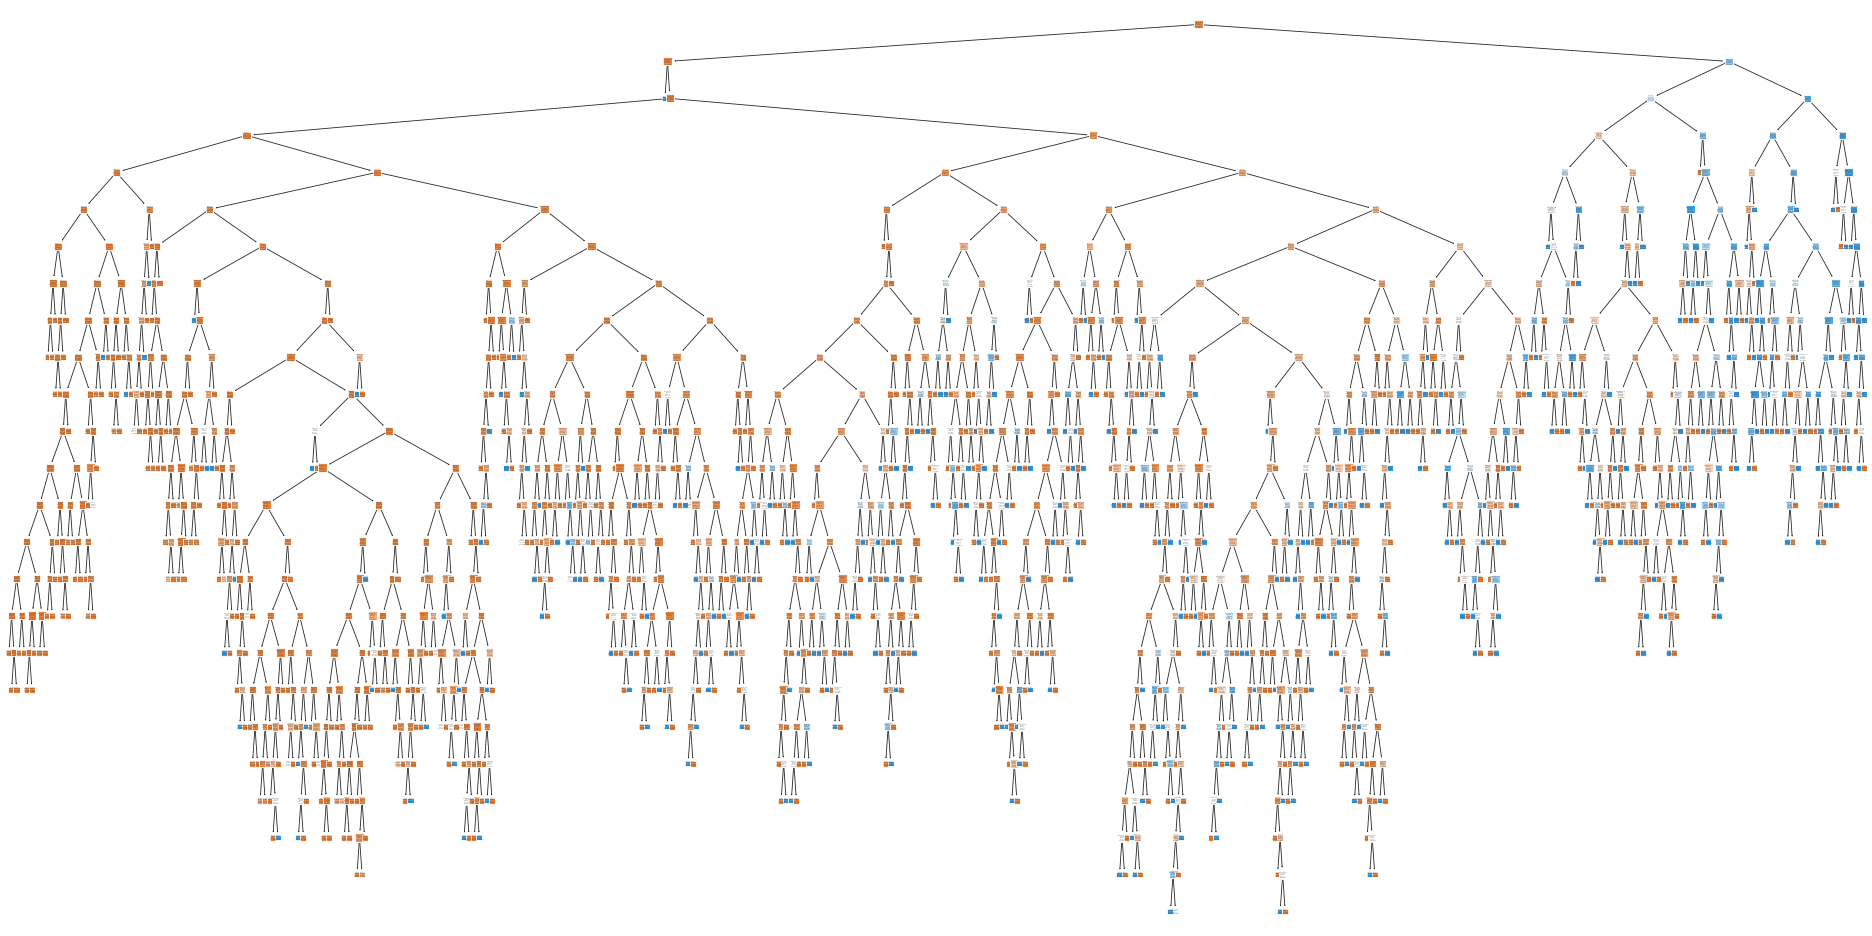

In [936]:
# визуализируем дерево решений
plt.figure(figsize=(40, 20), dpi=60)
tree.plot_tree(clf_tree, feature_names=X.columns, filled=True, class_names=['Stayed', 'Is gone']);

In [937]:
print(f'Accuracy  (общая точность) модели равна {round(accuracy_score(y_test, clf_tree.predict(X_test)), 3)}')
print(f'Precision (точность с учетом ложных срабатываний) модели равна {round(precision_score(y_test, clf_tree.predict(X_test)), 3)}')
print(f'Recall    (полнота верных срабатываний) модели равна {round(recall_score(y_test, clf_tree.predict(X_test)), 3)}')
print(f'f1_score  (соотношение точности и полноты) модели равна {round(f1_score(y_test, clf_tree.predict(X_test)), 3)}')

Accuracy  (общая точность) модели равна 0.927
Precision (точность с учетом ложных срабатываний) модели равна 0.538
Recall    (полнота верных срабатываний) модели равна 0.544
f1_score  (соотношение точности и полноты) модели равна 0.541


In [945]:
from sklearn.neighbors import KNeighborsClassifier


clf_knn = KNeighborsClassifier(n_neighbors = 24, leaf_size = 1).fit(X_train, y_train)

In [948]:
print(f'Accuracy  (общая точность) модели равна {round(accuracy_score(y_test, clf_knn.predict(X_test)), 3)}')
print(f'Precision (точность с учетом ложных срабатываний) модели равна {round(precision_score(y_test, clf_knn.predict(X_test)), 3)}')
print(f'Recall    (полнота верных срабатываний) модели равна {round(recall_score(y_test, clf_knn.predict(X_test)), 3)}')
print(f'f1_score  (соотношение точности и полноты) модели равна {round(f1_score(y_test, clf_knn.predict(X_test)), 3)}')

Accuracy  (общая точность) модели равна 0.943
Precision (точность с учетом ложных срабатываний) модели равна 0.772
Recall    (полнота верных срабатываний) модели равна 0.404
f1_score  (соотношение точности и полноты) модели равна 0.53


**Вывод: из всех моделей лучше всего справилась логистическая регрессия, но и в этом случае f1_score довольно низкий.**

### Какая задача отпугнула большее число пользователей?
Некоторые люди уходят с курса, когда пытаются решить одно задание много раз, у них не получается и они забрасывают дальнейшее обучение.

  Гипотеза: самый сложное задание решали больше раз, чем другие. Функция выводит значение, которое встречается в датасете чаще всего.

In [310]:
submissions.mode()

,step_id,timestamp,submission_status,user_id,date,day
0,31978,1491590313,wrong,12265,2017-04-07 18:38:33,2015-07-06


Гипотеза 2: Задание имеет наибольшее количество **неправильных** попыток (submission_status = wrong)  
  
Ход решения:
1. Отбираем все наблюдения где submission_status == 'wrong'
2. Группируем по полю step_id
3. Считаем количество наблюдений по полю submission_status
4. Сортируем в обратном порядке

In [311]:
submissions[submissions['submission_status'] == 'wrong'].groupby('step_id')['submission_status'] \
                                                        .value_counts() \
                                                        .sort_values(ascending=False) \
                                                        .head()

step_id  submission_status
31978    wrong                16084
32031    wrong                13373
32202    wrong                13002
33481    wrong                10300
32075    wrong                10003
Name: submission_status, dtype: int64

**Создателям курса нужно обратить внимание на стэпы 31978, 32031, 32202, 33481, 32075**